In [18]:
# CUDA 및 기본 의존성 설치
!apt-get update
!apt-get install -y python3-pip git

# PyTorch 설치 (CUDA 12.1 버전)
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# SAM2 관련 패키지 설치
!pip install -q opencv-python
!pip install -q pycocotools
!pip install -q matplotlib
!pip install -q numpy
!pip install -q pillow

# SAM2
!pip install -q git+https://github.com/facebookresearch/sam2.git

# General libraries
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Looking in indexes: https://download.pytorch.org/whl/cu121


In [20]:
### Import general libraries
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor
import PIL, cv2
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt
import numpy as np
import copy
from numpy import asarray


In [21]:
### import Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir, 
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/joseph/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/joseph/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/joseph/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/joseph/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [22]:
import os
import torch
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Check if the file already exists
if not os.path.exists("checkpoints/sam2.1_hiera_large.pt"):
    !mkdir -p checkpoints
    !wget -P checkpoints https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
elif not os.path.exists("configs/sam2.1_hiera_l.yaml"):
    # yaml 파일을 configs 디렉토리에 저장
    !mkdir -p configs
    !wget -P configs https://raw.githubusercontent.com/facebookresearch/sam2/main/sam2/configs/sam2.1/sam2.1_hiera_l.yaml
else:
    print("Files already exist, skipping download.")

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use float16 for the entire notebook
    torch.autocast("cuda", dtype=torch.float16).__enter__()
    print("using float16")

# Clear Hydra's global state before initializing
GlobalHydra.instance().clear()

# Initialize Hydra with relative path
initialize(config_path="configs", version_base="1.1")

sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "sam2.1_hiera_l.yaml"

# Build SAM2
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# Clear Hydra's global state before initializing - for sam2/__init__.py to work in order for open-cv preprocessing to properly work
GlobalHydra.instance().clear()



--2024-11-06 21:23:30--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.168.167.101, 3.168.167.115, 3.168.167.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.168.167.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898083611 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘checkpoints/sam2.1_hiera_large.pt’

sam2.1_hiera_large. 100%[===================>] 856.48M  55.3MB/s    in 16s     

2024-11-06 21:23:46 (54.7 MB/s) - ‘checkpoints/sam2.1_hiera_large.pt’ saved [898083611/898083611]

using device: cuda
using float16


MissingConfigException: Primary config directory not found.
Check that the config directory '/home/joseph/study/udemy/inpainting/SAM2_SD2/configs' exists and readable

Source image size:(3923, 5811)
Target image size:(512, 512)


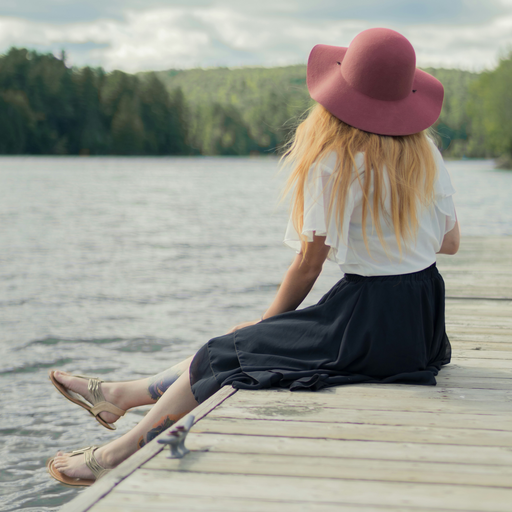

segmentation_image.shape : (512, 512, 3), segmentation_image.dtype : <class 'numpy.ndarray'>


In [5]:
# image

target_width, target_height = 512,512
source_image = Image.open('mix909-AsJirOOLN_s-unsplash.jpg')

width, height = source_image.size
print(f"Source image size:{source_image.size}")

# make square
source_image = source_image.crop((0,height-width, width, height))

# resize to target dimensions (to use less memory)
source_image = source_image.resize((target_width, target_height), Image.LANCZOS)
print(f"Target image size:{source_image.size}")

# convert into an array (to use it later with segmentation model)
segmentation_image = asarray(source_image)

display(source_image)

print(f"segmentation_image.shape : {segmentation_image.shape}, segmentation_image.dtype : {segmentation_image.__class__}")



In [6]:
# helper function : visualize masks and identifying number

def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort masks by area in descending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image, using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')



In [7]:
# set/run SAM mask_generator_2
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.975,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
    use_m2m=True,
)

masks = mask_generator_2.generate(segmentation_image)

# Print number of generated mask and keys attached to each of tehm
print(f"Number of masks generated:{len(masks)}")
print(masks[0].keys())


/home/joseph/miniconda3/envs/multimodal3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/home/joseph/study/udemy/inpainting/SAM2_SD3/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/joseph/study/udemy/inpainting/SAM2_SD3/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results

Number of masks generated:9
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


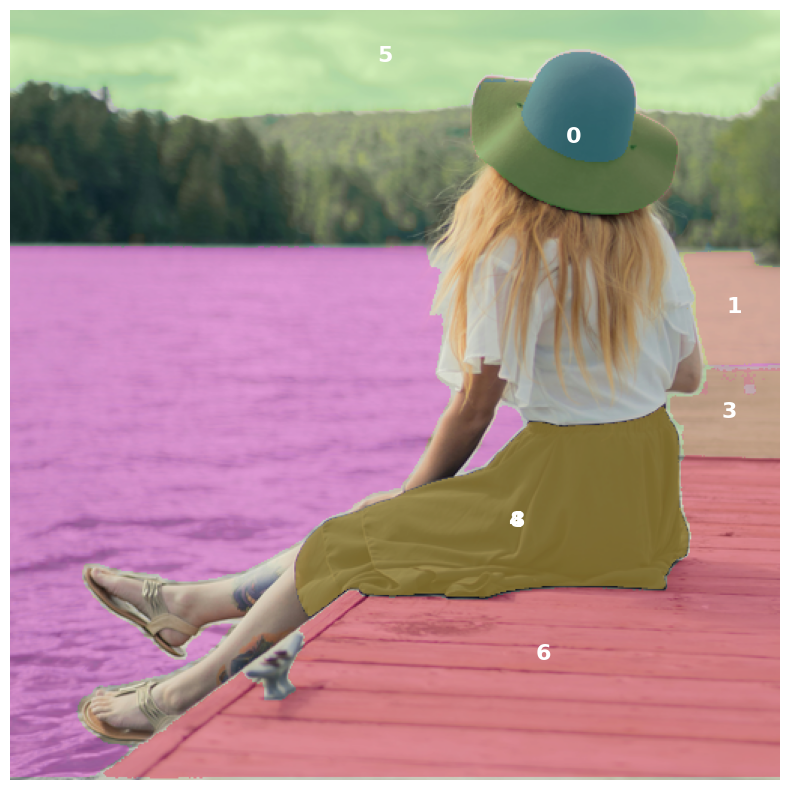

In [8]:
# Display masks with number
plt.figure(figsize=(10,10))
plt.imshow(source_image)
show_anns(masks[:])
plt.axis('off')
plt.show()

In [9]:
# Explore one of the keys of the mask
for i, values in enumerate(masks):
    print(f"{i}: Area: {values['area']} | IoU: {values['predicted_iou']}")


0: Area: 10605 | IoU: 0.9931640625
1: Area: 4179 | IoU: 0.98486328125
2: Area: 4345 | IoU: 0.9814453125
3: Area: 3917 | IoU: 0.97607421875
4: Area: 21903 | IoU: 0.99365234375
5: Area: 29885 | IoU: 0.99462890625
6: Area: 53919 | IoU: 0.9931640625
7: Area: 71489 | IoU: 0.98828125
8: Area: 21810 | IoU: 0.98486328125


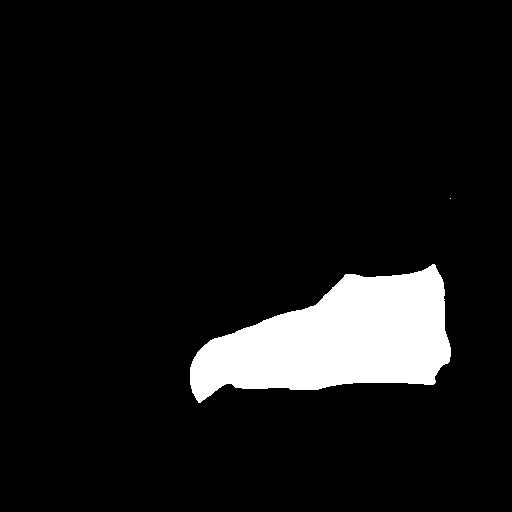

In [10]:
# Decide which mask to inpaint with
mask_index = 8

segmentation_mask = masks[mask_index]['segmentation']
stable_diffusion_mask = PIL.Image.fromarray(segmentation_mask)
display(stable_diffusion_mask)

(512, 512) (512, 512)


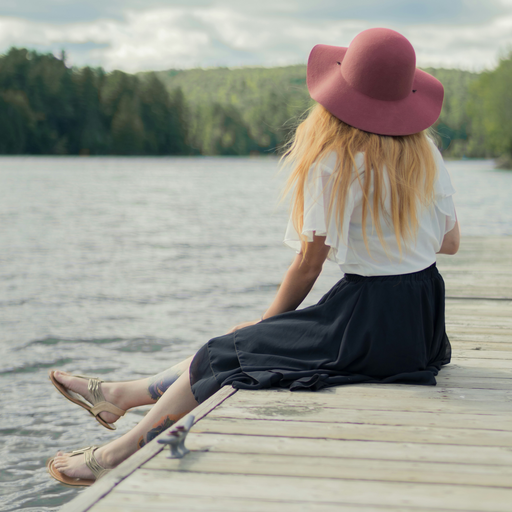

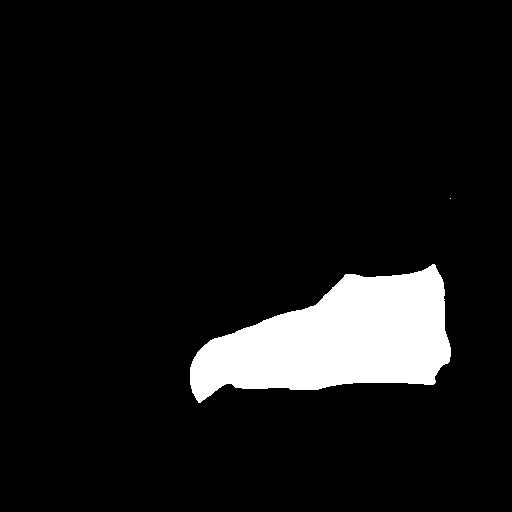

In [11]:
print(source_image.size, stable_diffusion_mask.size)
display(source_image)
display(stable_diffusion_mask)

In [12]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


In [15]:
print(pipe.config)

FrozenDict([('vae', ('diffusers', 'AutoencoderKL')), ('text_encoder', ('transformers', 'CLIPTextModelWithProjection')), ('text_encoder_2', ('transformers', 'CLIPTextModelWithProjection')), ('text_encoder_3', ('transformers', 'T5EncoderModel')), ('tokenizer', ('transformers', 'CLIPTokenizer')), ('tokenizer_2', ('transformers', 'CLIPTokenizer')), ('tokenizer_3', ('transformers', 'T5TokenizerFast')), ('transformer', ('diffusers', 'SD3Transformer2DModel')), ('scheduler', ('diffusers', 'FlowMatchEulerDiscreteScheduler')), ('_name_or_path', 'stabilityai/stable-diffusion-3-medium-diffusers')])


(512, 512) (512, 512)


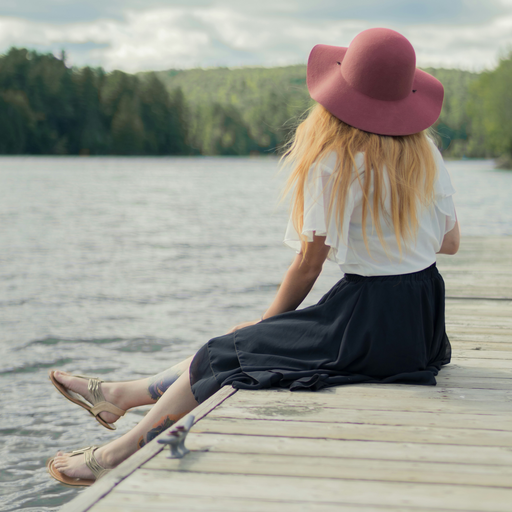

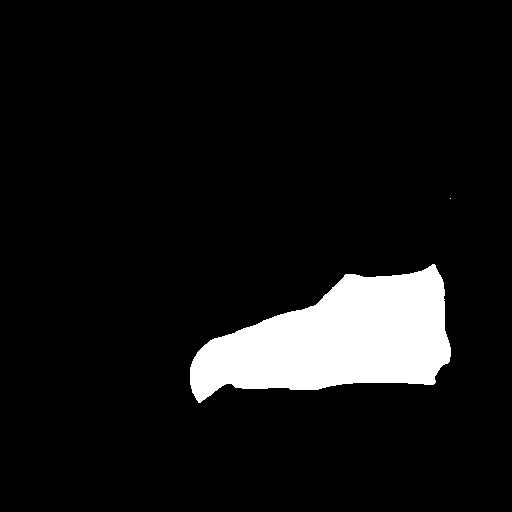

In [16]:
print(source_image.size, stable_diffusion_mask.size)
display(source_image)
display(stable_diffusion_mask)

In [24]:
# setup transformation prompts
num_images_per_prompt = 4
inpainting_prompts = ["a skirt full of text",  "red flowers", "blue flowers", "a zebra skirt"]
generator = torch.Generator(device="cuda").manual_seed(155)

# Run Stable Diffusion pipeline in inpainting mode
encoded_images = []
for i in range(num_images_per_prompt):
    image = pipe(prompt=inpainting_prompts[i], guidance_scale=9, num_inference_steps=80, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
    encoded_images.append(image)


create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 23.63 GiB of which 443.81 MiB is free. Including non-PyTorch memory, this process has 22.30 GiB memory in use. Of the allocated memory 21.50 GiB is allocated by PyTorch, and 344.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)